In [1]:
from utils import get_hyperedges

# Pyomo Solver

In [322]:
# from pyomo.environ import (
#     ConcreteModel, Var, Objective, ConstraintList, SolverFactory, NonNegativeReals, Binary, maximize
# )
# # Step 2: Create Pyomo model
# model = ConcreteModel()

# # Step 3: Define binary decision variables for each link (b_i)
# model.b = Var(range(V_H), domain=Binary)  # b[i] = 1 if link i is active, 0 otherwise

# # Step 4: Define the objective function (maximize throughput)
# def throughput(model):
#     total_throughput = 0
#     for i in range(V_H):
#         interference = sum(model.b[j] * I[i, j] for j in range(V_H) if j != i)  # Interference from other active links
#         denominator = N[i] + interference  # Noise + interference
#         total_throughput += (I[i,i] * model.b[i]) / denominator  # Contribution of link i to throughput
#     return total_throughput

# model.obj = Objective(rule=throughput, sense=maximize)

# # Step 5: Add constraints for hyperedges (each hyperedge has a threshold)
# model.constraints = ConstraintList()

# for e_idx, hyperedge in enumerate(hyperedges):
#     model.constraints.add(
#         sum(model.b[i] for i in hyperedge) <= len(hyperedge)-1
#     )

# # Step 6: Solve the model
# solver = SolverFactory('ipopt')  # Use Ipopt for nonlinear problems
# result = solver.solve(model, tee=True)

# # Step 7: Extract the results
# optimal_decisions = [model.b[i].value for i in range(V_H)]

# # Output the optimal link schedule
# print("Optimal link schedule:", optimal_decisions)
# print("Maximum throughput:", model.obj())

# Generate data

In [10]:
import numpy as np

# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges

# Signal strengths, noise power, and interference matrix
N = 0.1  # Noise power
I = np.random.rand(V_H, V_H)  # Interference matrix (I_ij)
S = np.diag(I)
# Thresholds for hyperedges
theta = 0.5
k = 4  # max hyperedge cardinality
# Hyperedges (list of node indices per hyperedge)
hyperedges = get_hyperedges(V_H, S, N, I, theta, k)

# Exhaustive Search Solver

In [3]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None

    for i in range(2**V_H):
        schedule = [int(x) for x in bin(i)[2:].zfill(V_H)]
        throughput = 0

        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            if sum(schedule[j] for j in hyperedge) == len(hyperedge):
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue

        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += (I[i,i] * schedule[i]) / denominator
        
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [4]:
best_throughput, best_schedule = exh_solver(V_H, E_H, V_H*[0.1], I, hyperedges)

print("Exhaustive search results:")
print("Optimal link schedule:", best_schedule)
print("Maximum throughput:", best_throughput)

Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Maximum throughput: 9.998196509314015


# Learning-Based

# Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [5]:
import torch
def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    hypergraph["n"] = V_H
    hypergraph["E"] = {}

    for e_idx, hyperedge in enumerate(hyperedges):
        hypergraph["E"][e_idx] = hyperedge


    hypergraph["I"] = I

    # incident matrix H
    H = np.zeros((V_H, len(hyperedges)))
    for e_idx, hyperedge in enumerate(hyperedges):
        for node in hyperedge:
            H[node, e_idx] = 1

    hypergraph["H"] = torch.FloatTensor(H)

    
    return hypergraph
    


In [6]:
hyp = hypergraph_generation(V_H, I, hyperedges)

In [7]:
hyp

{'n': 10,
 'E': {0: [0, 1, 2], 1: [2, 3, 4], 2: [4, 5, 6], 3: [6, 7, 8], 4: [8, 9]},
 'I': array([[0.01774818, 0.15675741, 0.15268429, 0.52231673, 0.7874287 ,
         0.6275112 , 0.85784869, 0.66281365, 0.93668158, 0.13547188],
        [0.6170873 , 0.37931599, 0.77540801, 0.47840438, 0.05722296,
         0.41535932, 0.94220379, 0.78248519, 0.02212366, 0.98922816],
        [0.10306183, 0.28679566, 0.76160361, 0.95951011, 0.56740732,
         0.93728347, 0.12851069, 0.90266366, 0.52647332, 0.20522818],
        [0.90219401, 0.05726015, 0.28421554, 0.32702643, 0.15513161,
         0.38683275, 0.58033024, 0.02674449, 0.81485031, 0.98006876],
        [0.96971377, 0.14384364, 0.93879924, 0.86467899, 0.93958268,
         0.84173735, 0.61622737, 0.23050766, 0.63078968, 0.70332246],
        [0.68257387, 0.06790644, 0.70275   , 0.95555323, 0.71665399,
         0.07851479, 0.06973225, 0.7441956 , 0.08693934, 0.78037906],
        [0.79751086, 0.81065084, 0.7151409 , 0.9757131 , 0.6655887 ,
       

# Training

In [8]:
import importlib, model, networks, utils
importlib.reload(networks)
importlib.reload(utils)

importlib.reload(model)

<module 'model' from '/app/hyp-sched/model.py'>

<span style="color:red">**HyperGCN**</span> is defined in <span style="color:cyan">**networks**</span> file, but it's core layer <span style="color:red">*HyperGraphConvolution*</span> is defined in <span style="color:cyan">**utils**</span>.<br /> If you want change the entire model you can put your model in <span style="color:cyan">**networks**</span> file.<br />
The training process is defined in the <span style="color:cyan">**model**</span> file, so if you defined a new model and want to use it in training process, please change that file.<br /> Also the <span style="color:red">**Gumbel+LinSatNet**</span> is defined in <span style="color:cyan">**utils**</span> but it is used in training process. Our custom loss function (negative of our objecive) is defined in <span style="color:cyan">**model**</span>, i double checked it with random inputs, so it should be fine.

In [13]:
import model
HyperGCN = model.initialise(hyp)


In [14]:
epochs = 500
HyperGCN = model.train(HyperGCN, hyp, epochs)

  8%|█████████▎                                                                                                             | 39/500 [00:00<00:02, 194.33it/s]

tensor([0.4773, 0.4772, 0.4771, 0.4772, 0.4772, 0.4772, 0.4772, 0.4772, 0.4772,
        0.4772], grad_fn=<SigmoidBackward0>)
Epoch: 0, Utility: 0.9122315049171448
tensor([0.4830, 0.4829, 0.4829, 0.4829, 0.4831, 0.4833, 0.4830, 0.4830, 0.4830,
        0.4830], grad_fn=<SigmoidBackward0>)
Epoch: 1, Utility: 0.9126450419425964
tensor([0.4867, 0.4867, 0.4867, 0.4867, 0.4867, 0.4867, 0.4867, 0.4866, 0.4865,
        0.4863], grad_fn=<SigmoidBackward0>)
Epoch: 2, Utility: 0.9129027128219604
tensor([0.4898, 0.4898, 0.4896, 0.4898, 0.4896, 0.4898, 0.4899, 0.4899, 0.4898,
        0.4898], grad_fn=<SigmoidBackward0>)
Epoch: 3, Utility: 0.913111686706543
tensor([0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4929, 0.4929, 0.4929,
        0.4929], grad_fn=<SigmoidBackward0>)
Epoch: 4, Utility: 0.9134031534194946
tensor([0.4960, 0.4961, 0.4959, 0.4960, 0.4960, 0.4961, 0.4961, 0.4961, 0.4960,
        0.4961], grad_fn=<SigmoidBackward0>)
Epoch: 5, Utility: 0.9135891199111938
tensor([0.4992, 0.4992,

 17%|███████████████████▊                                                                                                   | 83/500 [00:00<00:02, 208.18it/s]

tensor([0.6333, 0.6278, 0.6456, 0.6504, 0.6566, 0.6575, 0.6631, 0.6643, 0.6670,
        0.6641], grad_fn=<SigmoidBackward0>)
Epoch: 40, Utility: 0.9255434274673462
tensor([0.6365, 0.6375, 0.6412, 0.6543, 0.6571, 0.6664, 0.6690, 0.6716, 0.6761,
        0.6728], grad_fn=<SigmoidBackward0>)
Epoch: 41, Utility: 0.9245771765708923
tensor([0.6348, 0.6499, 0.6540, 0.6451, 0.6688, 0.6722, 0.6783, 0.6803, 0.6842,
        0.6808], grad_fn=<SigmoidBackward0>)
Epoch: 42, Utility: 0.9285638332366943
tensor([0.6519, 0.6638, 0.6708, 0.6703, 0.6740, 0.6730, 0.6695, 0.6815, 0.6865,
        0.6895], grad_fn=<SigmoidBackward0>)
Epoch: 43, Utility: 0.9282321333885193
tensor([0.6564, 0.6484, 0.6768, 0.6502, 0.6723, 0.6930, 0.6632, 0.6847, 0.6595,
        0.6815], grad_fn=<SigmoidBackward0>)
Epoch: 44, Utility: 0.9265497326850891
tensor([0.6714, 0.6713, 0.6930, 0.6877, 0.6960, 0.6894, 0.6846, 0.6940, 0.7068,
        0.7107], grad_fn=<SigmoidBackward0>)
Epoch: 45, Utility: 0.9293715953826904
tensor([0.6649, 

 25%|█████████████████████████████▉                                                                                        | 127/500 [00:00<00:01, 212.43it/s]

tensor([0.7191, 0.8240, 0.8297, 0.7962, 0.9016, 0.9224, 0.8444, 0.8052, 0.8236,
        0.9099], grad_fn=<SigmoidBackward0>)
Epoch: 84, Utility: 0.9434627294540405
tensor([0.6580, 0.6192, 0.7803, 0.7290, 0.8872, 0.9024, 0.8445, 0.9663, 0.9621,
        0.9726], grad_fn=<SigmoidBackward0>)
Epoch: 85, Utility: 0.9679577946662903
tensor([0.4709, 0.5990, 0.5959, 0.8059, 0.9236, 0.9505, 0.9529, 0.9542, 0.9465,
        0.9044], grad_fn=<SigmoidBackward0>)
Epoch: 86, Utility: 0.967383623123169
tensor([0.5564, 0.6711, 0.8098, 0.9169, 0.8755, 0.7266, 0.9269, 0.9323, 0.8922,
        0.9433], grad_fn=<SigmoidBackward0>)
Epoch: 87, Utility: 0.983806312084198
tensor([0.4468, 0.6171, 0.6378, 0.8867, 0.8302, 0.8066, 0.8945, 0.9633, 0.9689,
        0.9732], grad_fn=<SigmoidBackward0>)
Epoch: 88, Utility: 0.9829793572425842
tensor([0.4369, 0.7107, 0.6005, 0.7188, 0.8314, 0.9487, 0.9439, 0.9707, 0.9782,
        0.9769], grad_fn=<SigmoidBackward0>)
Epoch: 89, Utility: 0.9748063087463379
tensor([0.4397, 0.

 34%|████████████████████████████████████████▎                                                                             | 171/500 [00:00<00:01, 213.78it/s]

tensor([0.0884, 0.2023, 0.3849, 0.4961, 0.9095, 0.9836, 0.9525, 0.1326, 0.1212,
        0.7139], grad_fn=<SigmoidBackward0>)
Epoch: 128, Utility: 0.9413350820541382
tensor([0.0035, 0.0123, 0.0203, 0.0121, 0.7079, 0.9477, 0.1399, 0.9910, 0.9767,
        0.9947], grad_fn=<SigmoidBackward0>)
Epoch: 129, Utility: 1.178847312927246
tensor([3.9340e-04, 1.1227e-02, 3.9128e-02, 1.4104e-01, 8.1285e-01, 6.7074e-01,
        9.8823e-01, 9.8945e-01, 9.6132e-01, 8.3529e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 130, Utility: 1.1284586191177368
tensor([2.2927e-04, 9.2386e-02, 8.6370e-03, 6.6630e-02, 2.2534e-01, 9.5215e-01,
        9.8016e-01, 9.8291e-01, 9.4518e-01, 1.9821e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 131, Utility: 1.0272008180618286
tensor([0.0160, 0.0055, 0.0205, 0.0326, 0.9408, 0.3078, 0.9640, 0.9797, 0.9958,
        0.9952], grad_fn=<SigmoidBackward0>)
Epoch: 132, Utility: 1.2291535139083862
tensor([0.0045, 0.0032, 0.0028, 0.0314, 0.3863, 0.0576, 0.9116, 0.8857, 0.9662,
  

 39%|█████████████████████████████████████████████▌                                                                        | 193/500 [00:00<00:01, 200.01it/s]

tensor([6.6625e-09, 8.0098e-09, 5.3058e-10, 4.2171e-07, 6.0846e-08, 4.2777e-05,
        2.3951e-04, 4.1801e-04, 1.2715e-03, 2.5650e-03],
       grad_fn=<SigmoidBackward0>)
Epoch: 172, Utility: 0.03562674671411514
tensor([2.3022e-11, 1.6819e-10, 2.2908e-08, 2.3410e-07, 2.2973e-06, 1.7384e-02,
        3.6406e-03, 7.4574e-03, 1.1551e-02, 4.3923e-03],
       grad_fn=<SigmoidBackward0>)
Epoch: 173, Utility: 0.15597748756408691
tensor([3.0674e-11, 2.2303e-09, 2.3530e-09, 6.9407e-07, 3.3831e-05, 3.3311e-04,
        4.1607e-05, 8.2012e-07, 3.2998e-07, 5.5831e-06],
       grad_fn=<SigmoidBackward0>)
Epoch: 174, Utility: 0.0007398123852908611
tensor([3.5325e-13, 4.3190e-08, 1.9423e-08, 6.5614e-09, 2.8751e-02, 5.0749e-05,
        6.6293e-01, 2.1695e-02, 3.2878e-02, 2.2997e-04],
       grad_fn=<SigmoidBackward0>)
Epoch: 175, Utility: 1.1573173999786377
tensor([1.8226e-05, 2.4630e-07, 2.0115e-08, 8.2558e-10, 1.4764e-05, 1.2989e-02,
        4.0759e-01, 6.1477e-03, 1.3529e-04, 1.2304e-03],
       gra

 47%|███████████████████████████████████████████████████████▉                                                              | 237/500 [00:01<00:01, 207.01it/s]

tensor([5.6246e-17, 7.5332e-12, 6.3459e-10, 2.1039e-05, 1.5553e-04, 6.6163e-02,
        9.9258e-01, 8.2954e-01, 9.9948e-01, 9.5990e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 212, Utility: 1.2161434888839722
tensor([2.6176e-16, 7.2028e-12, 2.7738e-09, 7.7952e-09, 1.0701e-06, 1.2740e-04,
        1.3682e-07, 9.9972e-01, 8.0814e-01, 9.9996e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 213, Utility: 1.4627056121826172
tensor([3.3151e-13, 4.6719e-10, 9.6986e-13, 2.0454e-11, 3.9283e-09, 1.7154e-07,
        8.7034e-05, 9.9967e-01, 8.9408e-01, 3.3224e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 214, Utility: 1.3838951587677002
tensor([1.2050e-16, 4.2992e-14, 5.1390e-14, 2.9746e-10, 9.6908e-05, 1.2719e-03,
        2.4803e-01, 5.5842e-01, 9.9343e-01, 9.9903e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 215, Utility: 1.3201154470443726
tensor([8.6155e-11, 6.5785e-09, 1.7282e-09, 5.7231e-12, 5.6033e-05, 9.6789e-07,
        1.1013e-07, 9.7639e-01, 1.3544e-05, 8.7774e-03],
       grad_fn=

 56%|██████████████████████████████████████████████████████████████████                                                    | 280/500 [00:01<00:01, 196.98it/s]

tensor([2.3427e-18, 2.5634e-15, 1.3816e-14, 7.7968e-12, 6.0154e-05, 1.6388e-01,
        1.0000e+00, 1.0000e+00, 9.8652e-01, 8.8907e-07],
       grad_fn=<SigmoidBackward0>)
Epoch: 256, Utility: 1.1967134475708008
tensor([1.1271e-18, 2.3467e-15, 3.6534e-14, 3.9993e-02, 5.4098e-02, 7.0553e-01,
        9.8405e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       grad_fn=<SigmoidBackward0>)
Epoch: 257, Utility: 1.1318142414093018
tensor([1.5001e-23, 3.8673e-08, 5.3051e-08, 7.1255e-04, 1.0000e+00, 7.3632e-01,
        8.3772e-01, 5.6958e-07, 1.1650e-03, 1.3087e-02],
       grad_fn=<SigmoidBackward0>)
Epoch: 258, Utility: 1.072216272354126
tensor([1.4009e-21, 1.6627e-10, 2.1436e-10, 1.3647e-14, 1.2730e-05, 9.5089e-01,
        9.9967e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00],
       grad_fn=<SigmoidBackward0>)
Epoch: 259, Utility: 1.1155909299850464
tensor([2.0434e-22, 2.4048e-10, 1.2126e-09, 8.3441e-08, 9.9997e-01, 7.0199e-01,
        9.9999e-01, 1.6435e-07, 9.9505e-01, 9.9999e-01],
       grad_fn=<

 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 323/500 [00:01<00:00, 193.41it/s]

Epoch: 294, Utility: 0.0012837403919547796
tensor([5.0361e-24, 1.6603e-10, 1.0468e-13, 2.0622e-09, 9.9941e-01, 9.9940e-01,
        9.9995e-01, 9.9999e-01, 9.9995e-01, 9.9979e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 295, Utility: 1.1347754001617432
tensor([3.6827e-24, 3.8117e-09, 1.1446e-18, 3.0537e-14, 6.6769e-05, 1.5856e-02,
        9.9962e-01, 9.9992e-01, 9.9986e-01, 9.9953e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 296, Utility: 1.2460715770721436
tensor([1.7106e-22, 1.9535e-18, 5.0421e-10, 1.3205e-12, 6.6771e-07, 6.0627e-04,
        9.9000e-01, 9.0166e-01, 6.5291e-06, 9.7128e-10],
       grad_fn=<SigmoidBackward0>)
Epoch: 297, Utility: 1.396761178970337
tensor([1.4438e-16, 9.2092e-19, 2.7459e-18, 1.3003e-03, 5.2726e-04, 3.3961e-11,
        2.9291e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       grad_fn=<SigmoidBackward0>)
Epoch: 298, Utility: 1.3380868434906006
tensor([2.3936e-17, 4.4489e-19, 2.1271e-17, 1.5111e-17, 8.7277e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00

 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 367/500 [00:01<00:00, 204.53it/s]

tensor([6.1195e-30, 2.8532e-23, 5.4523e-18, 3.2849e-14, 9.6691e-05, 9.0670e-01,
        1.0000e+00, 9.9439e-01, 9.9965e-01, 9.6014e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 333, Utility: 1.1124149560928345
tensor([3.2450e-26, 1.8831e-22, 3.7523e-20, 1.3758e-19, 3.4571e-16, 9.5639e-07,
        7.5618e-06, 7.3588e-13, 5.4174e-03, 9.4186e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 334, Utility: 8.941783905029297
tensor([7.0608e-30, 1.0807e-22, 8.9593e-19, 1.7212e-22, 9.9177e-01, 4.0229e-07,
        2.7979e-05, 9.2261e-01, 1.0000e+00, 9.9999e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 335, Utility: 1.503104329109192
tensor([6.6542e-30, 1.3283e-21, 1.1680e-16, 1.1469e-07, 2.1363e-05, 4.7080e-01,
        6.3541e-01, 9.9169e-01, 9.8261e-01, 9.1483e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 336, Utility: 1.1846874952316284
tensor([7.9520e-25, 3.5006e-01, 1.5539e-19, 2.2225e-18, 9.3300e-01, 1.3400e-01,
        7.5078e-10, 2.5723e-02, 9.5996e-13, 7.6425e-13],
       grad_fn=<S

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 411/500 [00:02<00:00, 209.69it/s]

tensor([6.6216e-37, 2.3638e-17, 4.4701e-18, 1.2078e-17, 7.2490e-14, 9.9423e-01,
        1.0740e-04, 4.0938e-11, 1.7525e-10, 1.6116e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 377, Utility: 0.6365774273872375
tensor([9.2889e-27, 1.2020e-25, 3.6269e-25, 6.0898e-17, 8.4466e-13, 3.1741e-09,
        9.9995e-01, 2.6394e-17, 3.8261e-07, 8.6986e-03],
       grad_fn=<SigmoidBackward0>)
Epoch: 378, Utility: 2.1758310794830322
tensor([2.6125e-19, 2.4005e-14, 3.0385e-19, 3.1497e-16, 5.6273e-12, 1.1777e-11,
        2.2428e-17, 1.0000e+00, 7.1892e-15, 1.3774e-17],
       grad_fn=<SigmoidBackward0>)
Epoch: 379, Utility: 7.694724082946777
tensor([2.7579e-32, 5.0441e-18, 5.1434e-08, 2.1566e-12, 1.5200e-02, 1.2494e-17,
        1.2456e-07, 9.9995e-01, 1.0000e+00, 9.9999e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 380, Utility: 1.3909096717834473
tensor([0.0000e+00, 3.9311e-20, 4.8484e-20, 2.3587e-17, 2.3537e-15, 1.9610e-01,
        4.7843e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       grad_fn=<

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 455/500 [00:02<00:00, 211.97it/s]

tensor([8.9704e-38, 2.9340e-27, 2.7633e-22, 2.1847e-22, 3.8307e-04, 5.1914e-14,
        3.1916e-19, 9.9998e-01, 8.5299e-06, 9.9999e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 421, Utility: 2.5921549797058105
tensor([1.7688e-34, 8.5731e-23, 5.3421e-11, 2.6264e-21, 5.9402e-09, 3.5422e-07,
        9.8431e-01, 9.9977e-01, 2.3919e-04, 3.8415e-08],
       grad_fn=<SigmoidBackward0>)
Epoch: 422, Utility: 1.490992546081543
tensor([1.4966e-35, 8.0700e-31, 6.2423e-22, 2.7280e-17, 2.9961e-12, 4.7091e-01,
        1.0000e+00, 9.9996e-01, 9.9978e-01, 8.8682e-01],
       grad_fn=<SigmoidBackward0>)
Epoch: 423, Utility: 1.1508994102478027
tensor([0.0000e+00, 1.2313e-25, 9.4075e-25, 1.4553e-03, 4.6414e-24, 9.9864e-01,
        1.0000e+00, 3.0256e-08, 1.0238e-20, 4.4631e-17],
       grad_fn=<SigmoidBackward0>)
Epoch: 424, Utility: 2.483339309692383
tensor([1.2285e-07, 2.7399e-11, 7.2980e-14, 6.3566e-14, 8.7711e-12, 4.5362e-11,
        3.8128e-01, 9.9996e-01, 1.0000e+00, 1.0000e+00],
       grad_fn=<S

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 206.45it/s]

Epoch: 464, Utility: 0.7493027448654175
tensor([0.0000e+00, 3.4679e-20, 2.0800e-29, 8.8383e-27, 3.9258e-22, 7.5269e-13,
        1.9125e-11, 1.9326e-01, 1.2252e-19, 9.1105e-26],
       grad_fn=<SigmoidBackward0>)
Epoch: 465, Utility: 1.4871001243591309
tensor([1.6442e-20, 1.5851e-25, 3.3521e-26, 1.0006e-27, 3.3445e-11, 6.7774e-14,
        9.6559e-13, 1.2807e-10, 4.3122e-09, 1.9625e-03],
       grad_fn=<SigmoidBackward0>)
Epoch: 466, Utility: 0.019621774554252625
tensor([2.2155e-34, 1.2614e-23, 3.1378e-22, 3.0321e-14, 5.5963e-15, 1.9031e-13,
        3.6045e-06, 5.4475e-01, 2.3385e-04, 3.3366e-05],
       grad_fn=<SigmoidBackward0>)
Epoch: 467, Utility: 4.183197021484375
tensor([8.1551e-38, 4.5553e-32, 3.4573e-28, 4.6255e-21, 2.7340e-09, 2.2579e-08,
        9.9997e-01, 1.9418e-05, 1.0618e-26, 6.5434e-24],
       grad_fn=<SigmoidBackward0>)
Epoch: 468, Utility: 2.292998790740967
tensor([5.9784e-30, 6.4986e-28, 3.6721e-22, 8.6603e-25, 6.1345e-26, 8.4976e-20,
        5.9811e-18, 4.6556e-03, 

In [15]:
import matplotlib.pyplot as plt

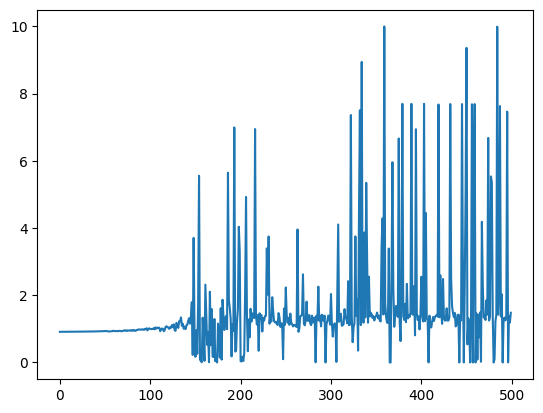

In [16]:
plt.plot(torch.stack(HyperGCN['utility']).detach().numpy())